<a href="https://colab.research.google.com/github/TafzeelAhmad/Tafzeel-Ahmad-0045/blob/main/TF_oel_045_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d prasunroy/natural-images
!unzip -q natural-images.zip -d natural_images


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 91% 310M/342M [00:01<00:00, 155MB/s]
100% 342M/342M [00:01<00:00, 206MB/s]


In [4]:
import os
import shutil
import random

original_data_dir = "natural_images/natural_images"
base_dir = "natural_images/split_data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    class_names = os.listdir(original_data_dir)

    for class_name in class_names:
        class_path = os.path.join(original_data_dir, class_name)
        if not os.path.isdir(class_path): continue
        images = os.listdir(class_path)
        random.shuffle(images)

        split_idx = int(0.8 * len(images))
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.4],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 5516 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [13]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

# Load ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True

# Freeze early layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build classifier
num_classes = train_generator.num_classes
model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50v2_natural_scene_best.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, min_lr=1e-6)

# Train
epochs = 8
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8527 - loss: 1.2943

173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 623ms/step - accuracy: 0.8532 - loss: 1.2929 - val_accuracy: 0.9964 - val_loss: 0.8829 - learning_rate: 1.0000e-04
Epoch 2/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9847 - loss: 0.9208

173/173 ━━━━━━━━━━━━━━━━━━━━ 95s 547ms/step - accuracy: 0.9847 - loss: 0.9207 - val_accuracy: 0.9971 - val_loss: 0.8575 - learning_rate: 1.0000e-04
Epoch 3/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9881 - loss: 0.8853

173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 555ms/step - accuracy: 0.9881 - loss: 0.8852 - val_accuracy: 0.9978 - val_loss: 0.8257 - learning_rate: 1.0000e-04
Epoch 4/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9927 - loss: 0.8487

173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 556ms/step - accuracy: 0.9927 - loss: 0.8486 - val_accuracy: 1.0000 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 5/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 530ms/step - accuracy: 0.9968 - loss: 0.8109 - val_accuracy: 0.9964 - val_loss: 0.7791 - learning_rate: 1.0000e-04
Epoch 6/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 521ms/step - accuracy: 0.9902 - loss: 0.7935 - val_accuracy: 0.9964 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 7/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 536ms/step - accuracy: 0.9931 - loss: 0.7654 - val_accuracy: 0.9971 - val_loss: 0.7274 - learning_rate: 1.0000e-04
Epoch 8/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.9960 - loss: 0.7358 - val_accuracy: 0.9971 - val_loss: 0.7047 - learning_rate: 1.0000e-04



Final Training Accuracy: 99.53%
Final Validation Accuracy: 99.71%


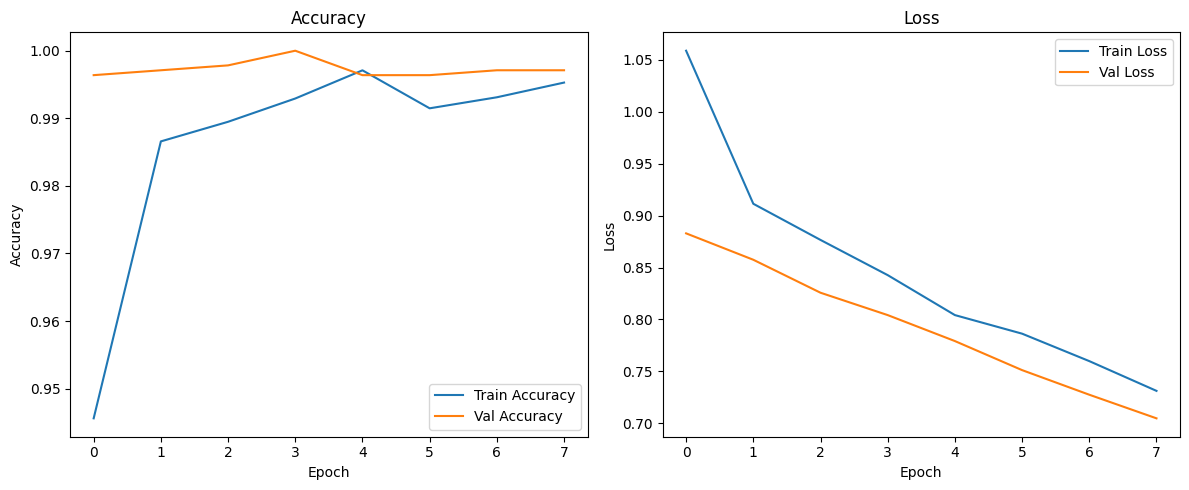

In [14]:
import matplotlib.pyplot as plt
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


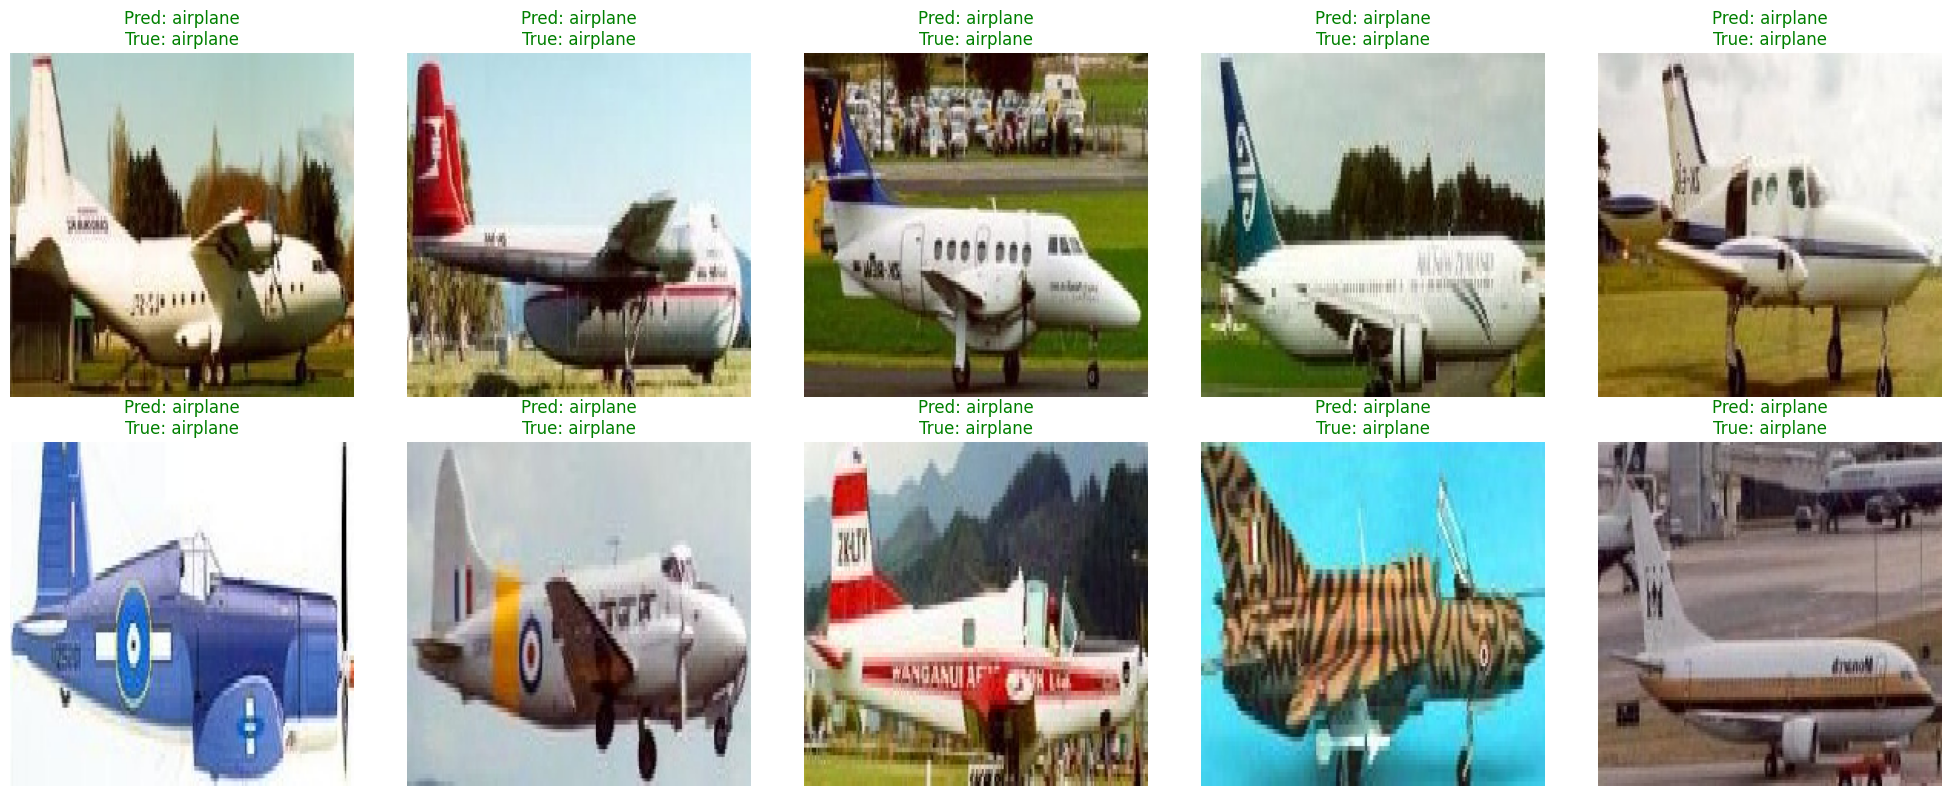

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Get class labels mapping
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Get a batch of test images
val_generator.reset()
x_test, y_test = next(val_generator)
preds = model.predict(x_test)
predicted_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Display 10 test images with predictions
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = x_test[i]
    plt.imshow(img)
    pred_label = idx_to_class[predicted_classes[i]]
    true_label = idx_to_class[true_classes[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()
